## Multivariate Time Series Forecasting with Deep Learning
### Predicting the price of Bitcoin and interpreting the results

This notebook runs the entire forecasting pipeline from data preparation to model training and interpretation.

Alternatively, everything can be run from the terminal as well (see README.md).

Prerequisite: Dataset has been downloaded (see README.md) and parameters have been updated if necessary (see /model/params.yaml).

In [2]:
!pip3 install shap

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.3/433.3 KB 3.8 MB/s eta 0:00:00a 0:00:01
  Using cached numba-0.55.1-cp39-cp39-macosx_10_14_x86_64.whl (2.3 MB)
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with dis

### Setup

In [22]:
import os
import yaml
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

os.chdir("../scripts")

import preprocess, train, inference, interpret

In [23]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']

# Create data

In [136]:
from yahoofinancials import YahooFinancials

def historical_yahoo_one(start = (datetime.now() - timedelta(days=20000)).strftime("%Y-%m-%d"),
                    end= datetime.now().strftime("%Y-%m-%d"), ticker = "BTC-USD", rename=True, featuring=True):#,"TSLA",'WFC', 'BAC', 'C' ,'EURUSD=X', 'JPY=X', 'GBPUSD=X', 'PRLAX', 'QASGX', 'HISFX']):

    yahoo_financials = YahooFinancials(ticker)
    historical_stock_prices = yahoo_financials.get_historical_price_data(start, end, 'daily')
    data = pd.DataFrame(historical_stock_prices[ticker]['prices'])
    return data

In [137]:
data = historical_yahoo_one()
col_names = list(col.capitalize() for col in data.columns)
data.columns = col_names
data.Date = data['Formatted_date']
data.drop('Formatted_date', axis=1, inplace=True)
data.Open.max()

67549.734375

### Load and Prepare the Data

In [138]:
print(os.getcwd())
#file_name = "BTC-USD.csv"
#file_name = "yahoo_data.csv"

#data = preprocess.load_data(file_name)
#col_names = list(data.columns)
#col_names[0] = 'Date'
#data.columns = col_names
#data.head(3)

/Users/puche99/Desktop/helpers/github/TimeSeriesDL/deep-forecasting/scripts


In [139]:
train_df, test_df = preprocess.prep_data(df=data, train_frac=0.5, plot_df=True)

Starting with data preparation...
Completed.


In [140]:
train_df.shape, test_df.shape

((1401, 7), (1401, 7))

### Explore the Data

In [141]:
plot_df = pd.read_csv(Path(data_dir, 'plot_df.csv'))
plot_df['Close_Change'] = plot_df.Close.pct_change(1)
plot_df = plot_df.dropna()

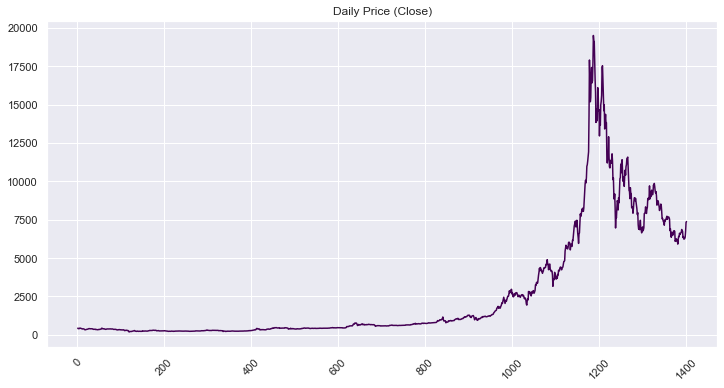

In [142]:
plot_df['Close'].plot(figsize=(12,6), rot=45, cmap='viridis')
plt.title('Daily Price (Close)')
plt.show()

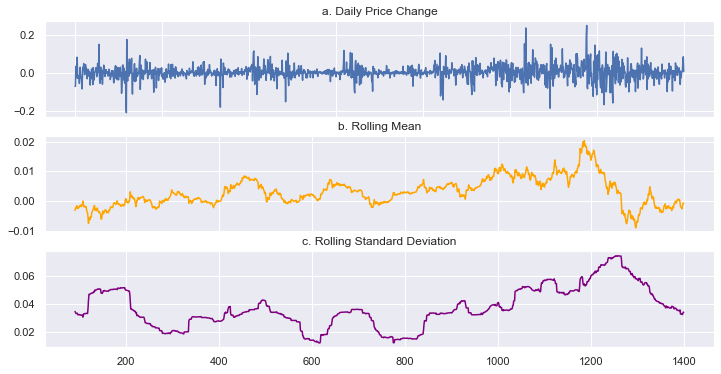

In [143]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plot_df['Close_Change'].plot(ax=axes[0], figsize=(12,6), rot=90, title='a. Daily Price Change', sharex=True)
plot_df['Close_Change'].rolling(90).mean().plot(ax=axes[1], figsize=(12,6), rot=90, title='b. Rolling Mean', color='orange')
plot_df['Close_Change'].rolling(90).std().plot(ax=axes[2], figsize=(12,6), rot=0, title='c. Rolling Standard Deviation', color='purple')
plt.show()

### Train the LSTM model

In [144]:
sequence_length = 30
batch_size = 8
n_epochs = 20
n_epochs_stop = 5
label_name = 'Close'

In [145]:
hist = train.train_model(train_df, test_df, label_name, sequence_length, batch_size, n_epochs, n_epochs_stop)

Starting with model training...
Epoch 1 train loss: 0.0028 test loss: 1.4823
Epoch 2 train loss: 0.0075 test loss: 1.5141
Epoch 3 train loss: 0.0157 test loss: 1.6417
Epoch 4 train loss: 0.0191 test loss: 1.473
Epoch 5 train loss: 0.026 test loss: 1.3494
Epoch 6 train loss: 0.0293 test loss: 1.4087
Epoch 7 train loss: 0.0286 test loss: 1.3295
Epoch 8 train loss: 0.0308 test loss: 1.2962
Epoch 9 train loss: 0.0296 test loss: 1.1726
Epoch 10 train loss: 0.0226 test loss: 1.1437
Epoch 11 train loss: 0.014 test loss: 1.1684
Epoch 12 train loss: 0.0109 test loss: 0.9713
Epoch 13 train loss: 0.0074 test loss: 0.8162
Epoch 14 train loss: 0.0061 test loss: 0.7675
Epoch 15 train loss: 0.0063 test loss: 0.7196
Epoch 16 train loss: 0.0058 test loss: 0.6752
Epoch 17 train loss: 0.0048 test loss: 0.7307
Epoch 18 train loss: 0.0045 test loss: 0.8232
Epoch 19 train loss: 0.0039 test loss: 0.8566
Epoch 20 train loss: 0.0031 test loss: 0.847
Completed.


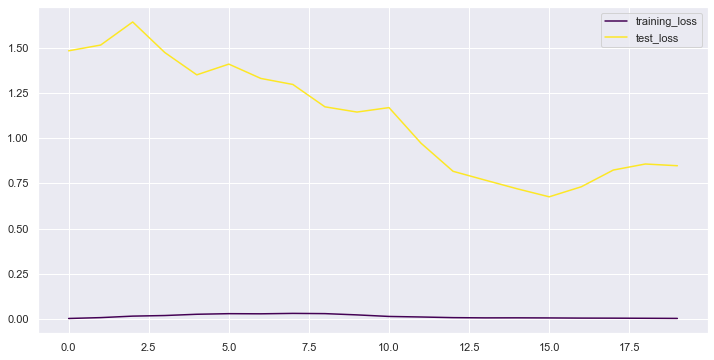

In [146]:
hist.plot(figsize=(12,6), cmap='viridis')
plt.show()

### Evaluate the model

In [147]:
predictions_descaled, labels_descaled = inference.predict(df=test_df,
                                                          label_name='Close',
                                                          sequence_length=sequence_length)

predictions_descaled.shape, predictions_descaled.shape

((1371,), (1371,))

In [148]:
print('Error on all test data:')
inference.print_loss_metrics(labels_descaled, predictions_descaled)
print('\n')
print('Error on partial test data:')
inference.print_loss_metrics(labels_descaled[:30], predictions_descaled[:30])

Error on all test data:
RMSE:  15821.39
MAE:  11919.98


Error on partial test data:
RMSE:  560.6
MAE:  428.94


In [149]:
df.shape
df.loc[df.shape[0]-20:]

,date,high,low,open,close,volume,adjclose,formatted_date
2783,1651363200,38627.859375,37585.789062,37713.265625,38469.093750,27002760110,38469.093750,2022-05-01
2784,1651449600,39074.972656,38156.562500,38472.187500,38529.328125,32922642426,38529.328125,2022-05-02
2785,1651536000,38629.996094,37585.621094,38528.109375,37750.453125,27326943244,37750.453125,2022-05-03
2786,1651622400,39902.949219,37732.058594,37748.011719,39698.371094,36754404490,39698.371094,2022-05-04
2787,1651708800,39789.281250,35856.515625,39695.746094,36575.140625,43106256317,36575.140625,2022-05-05
2788,1651795200,36624.359375,35482.132812,36573.183594,36040.921875,37795577489,36040.921875,2022-05-06
2789,1651881600,36129.925781,34940.824219,36042.503906,35501.953125,24375896406,35501.953125,2022-05-07
2790,1651968000,35502.941406,33878.964844,35502.941406,34059.265625,36763041910,34059.265625,2022-05-08
2791,1652054400,34222.074219,30296.953125,34060.015625,30296.953125,63355494961,30296.953125,2022-05-09
2792,1652140800,32596.308594,29944.802734,30273.654297,31022.906250,59811038817,31022.906250,2022-05-10


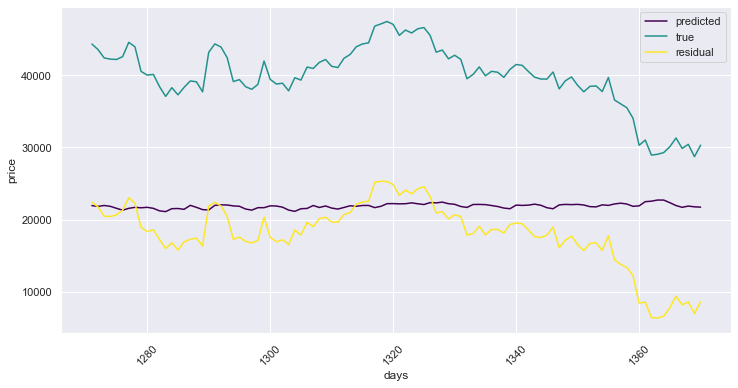

In [150]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['predicted'] = predictions_descaled
df_pred['true'] = labels_descaled
df_pred['residual'] = labels_descaled - predictions_descaled
df_pred = df_pred.loc[df_pred.shape[0]-100:]
df_pred.plot(figsize=(12,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.xlabel('days')
plt.ylabel('price')
plt.legend()
plt.show()

### Find important features

In [151]:
from train import TimeSeriesDataset, TSModel
from torch.utils.data import DataLoader
import torch
import shap

In [152]:
background_data_size = 900
test_sample_size = 100
sequence_length = 30

In [ ]:
shap_values = interpret.get_important_features(
    background_data_size,
    test_sample_size,
    sequence_length
)

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
shap_plot = pd.DataFrame(shap_values, columns=train_df.columns.tolist())
shap_plot['days'] = [i-31 for i in list(range(1,31))]
shap_plot.head()

In [ ]:
shap_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance")
plt.show()